In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table


In [2]:
fast = np.loadtxt('data/epics_fast.txt')
slow = np.loadtxt('data/epics_slow.txt')
superfast = np.loadtxt('data/epics_superfast.txt')

In [3]:
from astropy.stats import mad_std

In [5]:
douglas = Table.read('data/douglas2017.vot')
douglas.add_index('EPIC')

In [6]:
from scipy.ndimage import gaussian_filter1d
from scipy.optimize import minimize
from scipy.stats import skew
from interpacf import interpolated_acf

In [19]:
plots = False
smoothed_amps_fast = dict()
newstat_fast = dict()
periods = dict()

baseline_flux_at_flares = []
smoothed_flux_dist = []

for i in range(len(fast)): 
    times, fluxes = np.load("data/{0}.npy".format(int(fast[i])))
    clipped = ~np.isnan(fluxes)
    times, fluxes = times[clipped], fluxes[clipped]
    clip_flares = np.abs(fluxes - np.nanmedian(fluxes)) < 5*mad_std(fluxes, ignore_nan=True)

    # Remove polynomial trend
    fit = np.polyval(np.polyfit(times[clip_flares]-times.mean(), fluxes[clip_flares], 5), times-times.mean())
    fluxes /= fit
    
    period = douglas.loc[fast[i]]['Prot1']

    phases = (times % period) / period
    
    sort = np.argsort(phases)
    sort_clipped = np.argsort(phases[clip_flares])

    smoothed = gaussian_filter1d(fluxes[clip_flares][sort_clipped], 50, mode='nearest')
    
    smoothed_sorted = smoothed[np.argsort(times[sort_clipped])]
    
    interp_smoothed = np.interp(times, times[clip_flares], smoothed_sorted)
    outliers = (fluxes - interp_smoothed) > 0.015 #np.percentile(fluxes, 95)
    
    smoothed_amps_fast[fast[i]] = smoothed.max() - smoothed.min()
    
#     fft = np.abs(np.fft.rfft(fluxes))**2
#     freq = np.fft.rfftfreq(len(fluxes), times[1]-times[0])

    newstat_fast[fast[i]] = douglas.loc[fast[i]]["Pw1"]#fft[np.abs(freq - 1/period).argmin()]
    periods[fast[i]] = period

    if np.count_nonzero(outliers) < 100: 
        baseline_flux_at_flares.append(interp_smoothed[outliers])#[np.argmax(fluxes[outliers])])
        smoothed_flux_dist.append(smoothed)
        
    if plots: 
        fig, ax = plt.subplots(1, 3, figsize=(16, 3))
        ax[0].plot(times, fluxes)
        ax[1].plot(phases, fluxes, '.', alpha=0.5)
        ax[1].plot(phases[clip_flares][sort_clipped], smoothed, 'r')
        ax[2].loglog(freq, fft)
        ax[2].axhline(fft[1:].max())
        ax[2].axvline(1/period)
#         ax[2].axvline(freq[fft.argmax()])
#         ax[2].plot(times[outliers], fluxes[outliers], '.', alpha=0.5)
#         ax[2].plot(times[~outliers], fluxes[~outliers], '.', alpha=0.5)
#         ax[2].plot(times, interp_smoothed, ',')
#         ax[3].plot(interp_smoothed[outliers], fluxes[outliers], '.')
        
        ax[1].axhline(0.99*smoothed.min())
        ax[1].axhline(1.01*smoothed.max())
        ax[1].set_ylim([smoothed.min(), smoothed.max()])
        ax[1].axhline(np.median(fluxes[sort]), ls='--', color='k')
        ax[1].axhline(np.mean(fluxes[sort]), ls='-.', color='gray')
        
        ax[1].set_title("{0}".format(newstat_fast[fast[i]]))

        plt.show()

Anderson_ksampResult(statistic=-0.13307591418985151, critical_values=array([ 0.325,  1.226,  1.961,  2.718,  3.752]), significance_level=0.3999963173742384)


/Users/bmmorris/anaconda/lib/python3.5/site-packages/scipy/stats/morestats.py:1680: UserWarning: approximate p-value will be computed by extrapolation
  warnings.warn("approximate p-value will be computed by extrapolation")


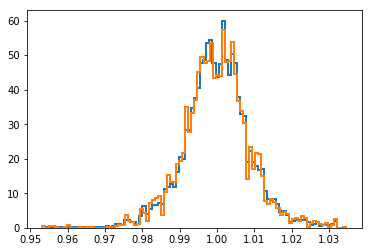

In [20]:
plt.hist(np.hstack(smoothed_flux_dist), bins=100, density=True, lw=2, histtype='step');
plt.hist(np.hstack(baseline_flux_at_flares), bins=100, density=True, lw=2, histtype='step');
from scipy.stats import anderson_ksamp
print(anderson_ksamp([np.hstack(smoothed_flux_dist), np.hstack(baseline_flux_at_flares)]))

In [21]:
plots = False
smoothed_amps_slow = dict()
newstat_slow = dict()


baseline_flux_at_flares = []
smoothed_flux_dist = []

for i in range(len(slow)): 
    times, fluxes = np.load("data/{0}.npy".format(int(slow[i])))
    if hasattr(times, "__len__"): 
        times, fluxes = np.load("data/{0}.npy".format(int(slow[i])))
        clipped = ~np.isnan(fluxes)
        times, fluxes = times[clipped], fluxes[clipped]
        clip_flares = np.abs(fluxes - np.nanmedian(fluxes)) < 5*mad_std(fluxes, ignore_nan=True)

        # Remove polynomial trend
        fit = np.polyval(np.polyfit(times[clip_flares]-times.mean(), fluxes[clip_flares], 5), times-times.mean())
        fluxes /= fit

        period = douglas.loc[slow[i]]['Prot1']

        phases = (times % period) / period

        sort = np.argsort(phases)
        sort_clipped = np.argsort(phases[clip_flares])

        smoothed = gaussian_filter1d(fluxes[clip_flares][sort_clipped], 50, mode='nearest')

        smoothed_sorted = smoothed[np.argsort(times[sort_clipped])]

        interp_smoothed = np.interp(times, times[clip_flares], smoothed_sorted)
        outliers = (fluxes - interp_smoothed) > 0.015 #np.percentile(fluxes, 95)

        smoothed_amps_slow[slow[i]] = smoothed.max() - smoothed.min()

    #     fft = np.abs(np.fft.rfft(fluxes))**2
    #     freq = np.fft.rfftfreq(len(fluxes), times[1]-times[0])

        if np.count_nonzero(outliers) < 100: 
            baseline_flux_at_flares.append(interp_smoothed[outliers])#[np.argmax(fluxes[outliers])])
            smoothed_flux_dist.append(smoothed)

Anderson_ksampResult(statistic=243.69630149703727, critical_values=array([ 0.325,  1.226,  1.961,  2.718,  3.752]), significance_level=inf)


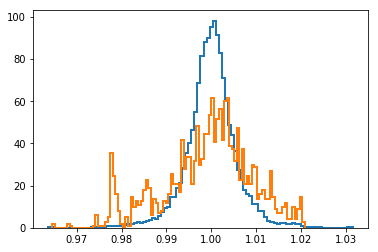

In [22]:
plt.hist(np.hstack(smoothed_flux_dist), bins=100, density=True, lw=2, histtype='step');
plt.hist(np.hstack(baseline_flux_at_flares), bins=100, density=True, lw=2, histtype='step');
print(anderson_ksamp([np.hstack(smoothed_flux_dist), np.hstack(baseline_flux_at_flares)]))

In [23]:
plots = False
smoothed_amps_superfast = dict()
newstat_superfast = dict()

baseline_flux_at_flares = []
smoothed_flux_dist = []

for i in range(len(superfast)): 
    times, fluxes = np.load("data/{0}.npy".format(int(superfast[i])))
    if hasattr(times, "__len__"): 
        times, fluxes = np.load("data/{0}.npy".format(int(superfast[i])))
        clipped = ~np.isnan(fluxes)
        times, fluxes = times[clipped], fluxes[clipped]
        clip_flares = np.abs(fluxes - np.nanmedian(fluxes)) < 5*mad_std(fluxes, ignore_nan=True)

        # Remove polynomial trend
        fit = np.polyval(np.polyfit(times[clip_flares]-times.mean(), fluxes[clip_flares], 5), times-times.mean())
        fluxes /= fit

        phases = (times % period) / period

        sort = np.argsort(phases)
        sort_clipped = np.argsort(phases[clip_flares])

        smoothed = gaussian_filter1d(fluxes[clip_flares][sort_clipped], 50, mode='nearest')

        smoothed_sorted = smoothed[np.argsort(times[sort_clipped])]

        interp_smoothed = np.interp(times, times[clip_flares], smoothed_sorted)
        outliers = (fluxes - interp_smoothed) > 0.015 #np.percentile(fluxes, 95)

        smoothed_amps_superfast[superfast[i]] = smoothed.max() - smoothed.min()

    #     fft = np.abs(np.fft.rfft(fluxes))**2
    #     freq = np.fft.rfftfreq(len(fluxes), times[1]-times[0])

        if np.count_nonzero(outliers) < 100: 
            baseline_flux_at_flares.append(interp_smoothed[outliers])#[np.argmax(fluxes[outliers])])
            smoothed_flux_dist.append(smoothed)

Anderson_ksampResult(statistic=39.109362995951003, critical_values=array([ 0.325,  1.226,  1.961,  2.718,  3.752]), significance_level=0.04745372849325029)


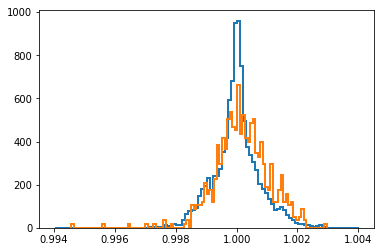

In [24]:
plt.hist(np.hstack(smoothed_flux_dist), bins=100, density=True, lw=2, histtype='step');
plt.hist(np.hstack(baseline_flux_at_flares), bins=100, density=True, lw=2, histtype='step');
print(anderson_ksamp([np.hstack(smoothed_flux_dist), np.hstack(baseline_flux_at_flares)]))